In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gensim
tqdm.pandas()
from gensim.models import LdaMulticore
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")


In [2]:
sns.set()

In [3]:
df_playlists = pd.read_csv('full_scraped_playlists.csv')
df_playlists.drop(columns=['Unnamed: 0'], inplace=True)
df_playlists.columns

Index(['song_id', 'playlist_id', 'playlist_name', 'user_id', 'followers'], dtype='object')

In [4]:
df_songs = pd.read_csv('scraped_song_ids.csv')
df_songs.drop(columns=['Unnamed: 0'], inplace=True)
df_songs.columns

Index(['song_id', 'artist', 'track', 'popularity'], dtype='object')

In [5]:
df_songs.drop_duplicates(subset=['song_id','artist','track'], inplace=True)

In [6]:
joined_df = pd.merge(df_playlists,df_songs,left_on='song_id',right_on='song_id',how='left')

In [7]:
joined_df.shape

(5319817, 8)

In [8]:
#drops playlists with repeat songs? will skew vector results by
joined_df.shape[0] - joined_df.drop_duplicates().shape[0]

104407

In [9]:
joined_df.drop_duplicates(inplace=True)

In [10]:
missing_songs = joined_df[joined_df.artist.isnull()==True]

In [11]:
#only 3286 missing songs NICE!!!!
missing_songs.shape

(3286, 8)

In [12]:
joined_df.dropna(inplace=True)

In [13]:
joined_df.shape

(5210462, 8)

In [14]:
joined_df.isnull().sum()

song_id          0
playlist_id      0
playlist_name    0
user_id          0
followers        0
artist           0
track            0
popularity       0
dtype: int64

In [15]:
joined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5210462 entries, 0 to 5319816
Data columns (total 8 columns):
song_id          object
playlist_id      object
playlist_name    object
user_id          object
followers        float64
artist           object
track            object
popularity       float64
dtypes: float64(2), object(6)
memory usage: 357.8+ MB


Text(0, 0.5, 'Songs on Playlist')

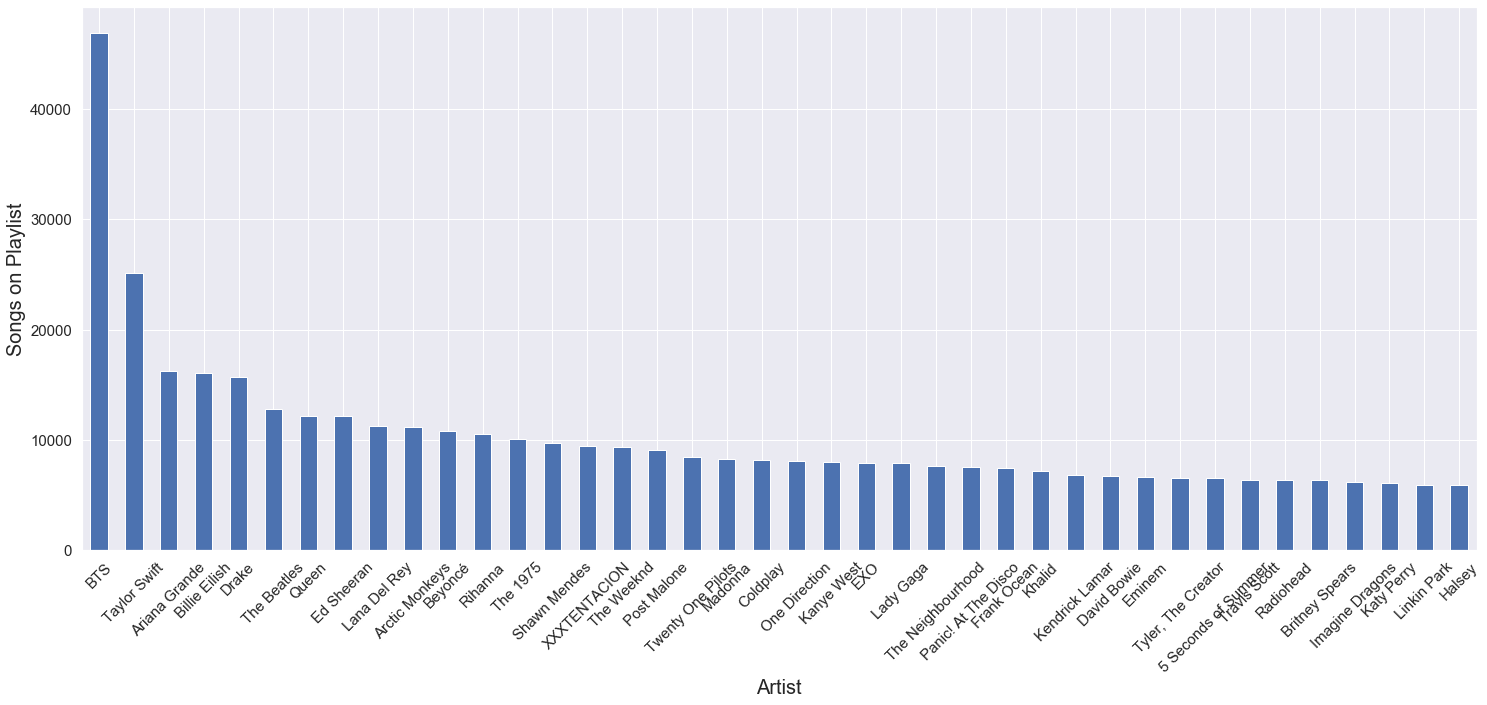

In [67]:
ax = joined_df.artist.value_counts()[0:40].plot(kind='bar', figsize=(25, 10), rot=45, fontsize=15)
ax.set_xlabel("Artist", fontsize=20)
ax.set_ylabel("Songs on Playlist", fontsize=20)



In [19]:
pivot_table = joined_df.pivot_table(index=['playlist_id'],
                                    values=['artist'],
                                    aggfunc=lambda x: '|'.join(str(v) for v in x))

In [20]:
pivot_table['tokens'] = pivot_table.artist.progress_apply(lambda x: x.split('|'))

100%|██████████| 101669/101669 [00:01<00:00, 72461.71it/s]


In [32]:
pivot_table.shape

(101669, 2)

In [21]:
from gensim.artistpora import Dictionary
from gensim.matutils import sparse2full

docs_dict = Dictionary(pivot_table.tokens)
docs_dict.filter_extremes(no_below=100, no_above=0.2)
docs_dict.compactify()

In [22]:
docs_corpus = [docs_dict.doc2bow(doc) for doc in pivot_table.tokens]

In [28]:
ldamodel = LdaMulticore(docs_corpus, id2word=docs_dict, num_topics=4,workers=4)

In [29]:
ldamodel.show_topics()

[(0,
  '0.027*"Taylor Swift" + 0.014*"Queen" + 0.010*"The Beatles" + 0.008*"David Bowie" + 0.008*"Madonna" + 0.007*"Radiohead" + 0.007*"Pink Floyd" + 0.006*"The Rolling Stones" + 0.006*"The Cure" + 0.005*"Elton John"'),
 (1,
  '0.008*"Daddy Yankee" + 0.008*"Glee Cast" + 0.008*"Ed Sheeran" + 0.007*"GOT7" + 0.007*"Shawn Mendes" + 0.006*"J Balvin" + 0.005*"Avicii" + 0.005*"My Chemical Romance" + 0.005*"Johann Sebastian Bach" + 0.005*"David Guetta"'),
 (2,
  '0.054*"BTS" + 0.011*"Billie Eilish" + 0.009*"Lana Del Rey" + 0.009*"Arctic Monkeys" + 0.008*"The 1975" + 0.007*"Frank Ocean" + 0.007*"The Neighbourhood" + 0.006*"Tyler, The Creator" + 0.006*"Rex Orange County" + 0.005*"Daniel Caesar"'),
 (3,
  '0.014*"Ariana Grande" + 0.012*"Drake" + 0.009*"Rihanna" + 0.008*"One Direction" + 0.008*"Beyoncé" + 0.008*"XXXTENTACION" + 0.007*"Post Malone" + 0.007*"The Weeknd" + 0.006*"Lady Gaga" + 0.006*"Britney Spears"')]

In [30]:
genre_lda = pyLDAvis.gensim.prepare(ldamodel, docs_corpus, docs_dict)

In [31]:
genre_lda

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.080690  0.033556       1        1  30.263927
2     -0.100936 -0.185928       2        1  28.070816
0      0.244072 -0.021350       3        1  24.906713
1     -0.062446  0.173723       4        1  16.758547, topic_info=     Category          Freq                   Term         Total  loglift  \
162   Default  47441.000000                    BTS  47441.000000  30.0000   
957   Default  26057.000000           Taylor Swift  26057.000000  29.0000   
103   Default  12902.000000                  Queen  12902.000000  28.0000   
251   Default  16806.000000          Ariana Grande  16806.000000  27.0000   
134   Default   4774.000000           Daddy Yankee   4774.000000  26.0000   
87    Default   6701.000000            David Bowie   6701.000000  25.0000   
2247  Default   4605.000000              Glee Cast   4605.000000  24.0000   
175   Default   8572.000000          One Direction   8572.000000  23.0000   
485   Default  12921.000000            The Beatles  12921.000000  22.0000   
125   Default   4646.000000                   GOT7   4646.000000  21.0000   
312   Default   5703.000000             Pink Floyd   5703.000000  20.0000   
513   Default   7986.000000                Madonna   7986.000000  19.0000   
337   Default  15609.000000                  Drake  15609.000000  18.0000   
688   Default   3865.000000               J Balvin   3865.000000  17.0000   
762   Default   7694.000000            Frank Ocean   7694.000000  16.0000   
218   Default   6368.000000         Britney Spears   6368.000000  15.0000   
488   Default   5656.000000     The Rolling Stones   5656.000000  14.0000   
482   Default   6455.000000              Radiohead   6455.000000  13.0000   
11    Default  11907.000000           Lana Del Rey  11907.000000  12.0000   
24    Default  16214.000000          Billie Eilish  16214.000000  11.0000   
179   Default   7957.000000      The Neighbourhood   7957.000000  10.0000   
472   Default   4624.000000             Elton John   4624.000000   9.0000   
221   Default  11652.000000             Ed Sheeran  11652.000000   8.0000   
410   Default   6445.000000           Travis Scott   6445.000000   7.0000   
2674  Default   2648.000000  Johann Sebastian Bach   2648.000000   6.0000   
66    Default  10892.000000                Rihanna  10892.000000   5.0000   
896   Default   4871.000000               The Cure   4871.000000   4.0000   
838   Default   9783.000000           XXXTENTACION   9783.000000   3.0000   
107   Default  10152.000000               The 1975  10152.000000   2.0000   
462   Default   5417.000000      Rex Orange County   5417.000000   1.0000   
...       ...           ...                    ...           ...      ...   
971    Topic4   1002.348267   Ludwig van Beethoven   1088.474121   1.7038   
2354   Topic4    846.119873       Ludovico Einaudi    909.507629   1.7140   
430    Topic4   2394.603760              Bad Bunny   2789.653076   1.6336   
690    Topic4    918.917847                 Plan B    995.907959   1.7058   
153    Topic4   1318.455688                    Jul   1480.696167   1.6702   
787    Topic4   1646.829712                 Maluma   1892.005371   1.6475   
125    Topic4   3695.680176                   GOT7   4646.275391   1.5574   
703    Topic4   2791.409180                 Avicii   3714.961182   1.5004   
1328   Topic4   1720.543091       MC Kevin o Chris   2142.879150   1.5668   
3158   Topic4   1570.914795            Hans Zimmer   1930.223389   1.5803   
2986   Topic4    997.171265                 Djonga   1106.170044   1.6825   
1001   Topic4   1390.759399             ANAVITÓRIA   1719.555664   1.5740   
1349   Topic4   1939.566040                   Kygo   2759.599121   1.4336   
26     Topic4   2772.168701    My Chemical Romance   4579.991211   1.2842   
965    Topic4   2473.276855           David Guetta   3943.962402   1.3196   
1352   Topic4 

In [68]:
pyLDAvis.save_html(genre_lda, 'lda_NEW_genre_4_topic.html')

In [ ]:
texts = list(pivot_table.tokens)

In [37]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile


# path = get_tmpfile("word2vec.model")
# model = Word2Vec(texts, size=300, window=10, min_count=100, workers=4, sg=1, negative=7, hs=0)

In [38]:
model = Word2Vec.load("/Users/matt/programming/flatiron/spotify_playlists/10window_word2vec.model")

In [39]:
model.wv.most_similar('Phoebe Bridgers')

[('Julien Baker', 0.7096861600875854),
 ('Haley Heynderickx', 0.6783092021942139),
 ('Lucy Dacus', 0.6529959440231323),
 ('Liza Anne', 0.6123979091644287),
 ('Angelo De Augustine', 0.611176609992981),
 ('Fenne Lily', 0.605137825012207),
 ('Lady Lamb', 0.5991477370262146),
 ('Better Oblivion Community Center', 0.5938686728477478),
 ('Chastity Belt', 0.5925945043563843),
 ('Henry Jamison', 0.5908191204071045)]

In [94]:
# model.save("10window_word2vec.model")

In [40]:
def analogy(x1, x2, y1):
    
    result = model.most_similar(positive=[y1, x2], negative=[x1])
    return result

In [41]:
analogy('Katy Perry', 'Kanye West', 'Sia')

[('KIDS SEE GHOSTS', 0.45697763562202454),
 ('Desiigner', 0.3825467824935913),
 ('Joey Bada$$', 0.3708038926124573),
 ('Danny Brown', 0.3660980463027954),
 ('Ab-Soul', 0.3651217222213745),
 ('Royce Da 5\'9"', 0.36198848485946655),
 ('Raekwon', 0.3593319356441498),
 ('Earl Sweatshirt', 0.35864612460136414),
 ('Jalen Santoy', 0.3560953438282013),
 ('Kid Cudi', 0.35559582710266113)]

In [229]:
model.wv.most_similar('Young Thug')

[('Quality Control', 0.6939061284065247),
 ('NLE Choppa', 0.6931595802307129),
 ('Lil Gotit', 0.6892422437667847),
 ('Lil Keed', 0.6695393323898315),
 ('Roddy Ricch', 0.6652404069900513),
 ('Key Glock', 0.6634103059768677),
 ('Swae Lee', 0.6549409627914429),
 ('Pop Smoke', 0.6546870470046997),
 ('Gunna', 0.6539862751960754),
 ('Lil Tecca', 0.6514034271240234)]

In [42]:
model.wv.most_similar('Tame Impala')

[('Pond', 0.6015661954879761),
 ('Moses Gunn Collective', 0.5707148313522339),
 ('Mild High Club', 0.5323584079742432),
 ('Mac DeMarco', 0.5316274166107178),
 ("Melody's Echo Chamber", 0.5240697264671326),
 ('Babe Rainbow', 0.5034385323524475),
 ('Sports', 0.49749916791915894),
 ('Foxygen', 0.49242615699768066),
 ('Kane Strang', 0.4904530346393585),
 ('The Neighbourhood', 0.4864231050014496)]

In [73]:
model.wv.most_similar('The National')

[('Lady Lamb', 0.5076968669891357),
 ('Josh Ritter', 0.5053383111953735),
 ('Phosphorescent', 0.5011557340621948),
 ('Lucy Dacus', 0.49398794770240784),
 ('Yeasayer', 0.4932708740234375),
 ('Bedouine', 0.4868927001953125),
 ('The War On Drugs', 0.4863227307796478),
 ('Mercury Rev', 0.48340511322021484),
 ('Grizzly Bear', 0.48094308376312256),
 ('Damien Jurado', 0.48039090633392334)]

In [76]:
model.wv.most_similar('Men At Work')

[('Culture Club', 0.6634784936904907),
 ('The Outfield', 0.6570075750350952),
 ('Spandau Ballet', 0.6487559080123901),
 ('Kim Carnes', 0.6267982721328735),
 ('Nik Kershaw', 0.6240929961204529),
 ('Cutting Crew', 0.6230958700180054),
 ('Fine Young Cannibals', 0.6222957372665405),
 ('Kajagoogoo', 0.6217515468597412),
 ('Sandra', 0.6213288903236389),
 ('Baltimora', 0.6206351518630981)]

In [178]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [46]:
"Creates and TSNE model and plots it"
labels = []
tokens = []

for word in model.wv.vocab:
    tokens.append(model[word])
    labels.append(word)
    
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(tokens)

In [47]:
new_values

array([[-47.07965  , -17.662683 ],
       [-46.722836 , -17.660994 ],
       [-45.207684 ,   9.7462435],
       ...,
       [ 40.370846 ,   3.3145723],
       [ 40.19322  ,   3.165478 ],
       [ 40.435486 ,   3.267585 ]], dtype=float32)

In [48]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

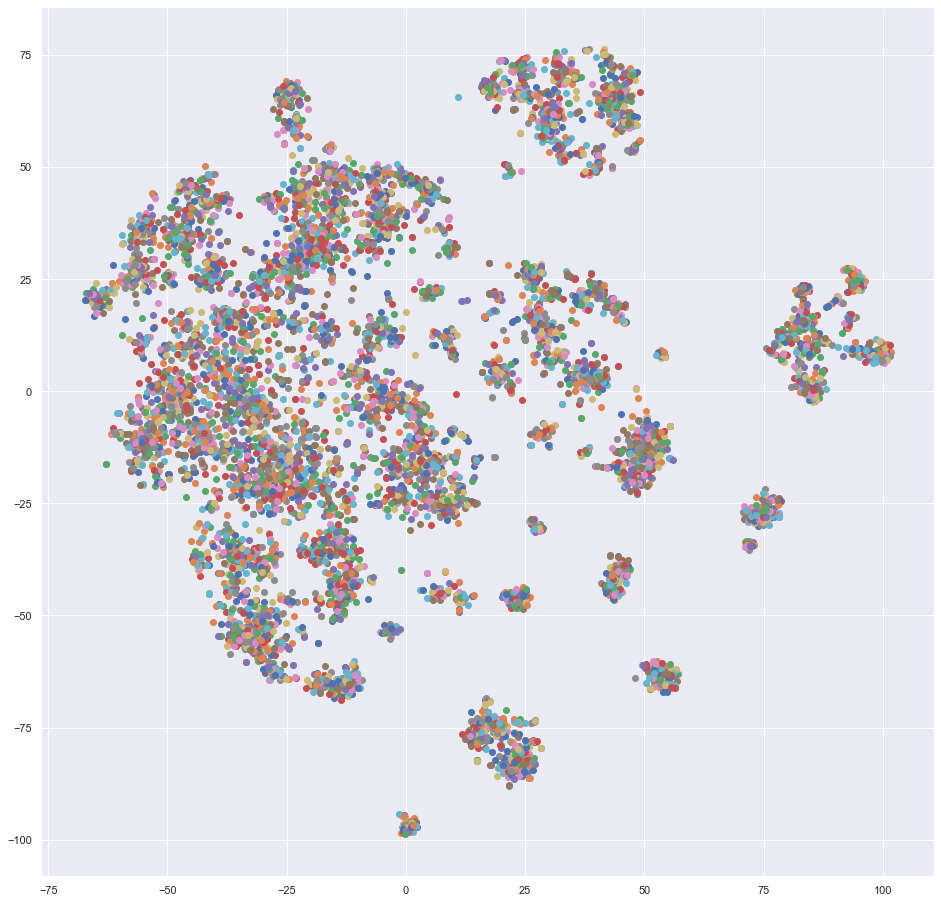

In [54]:
plt.figure(figsize=(16, 16)) 

for i in range(len(x)):
    plt.scatter(x[i],y[i])
    
plt.show()

In [52]:
d = {'artist': labels,'x': x, 'y': y}
tsne_df = pd.DataFrame(data=d)

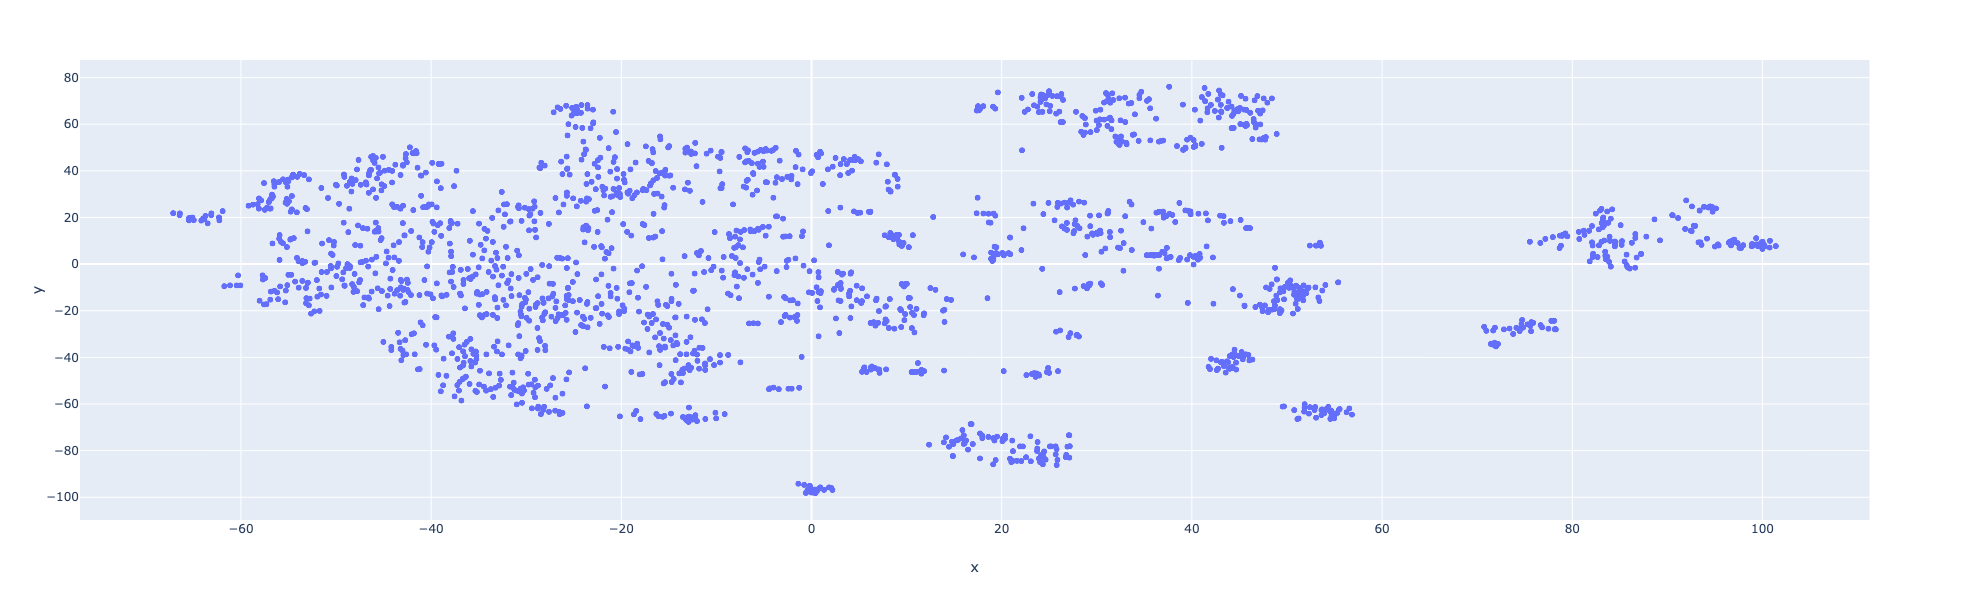

In [69]:
import plotly.express as px
fig = px.scatter(tsne_df.sample(n=2000), x='x', y='y',hover_data=['artist'])
fig.show()

In [63]:
pivot_table.tokens.progress_apply(lambda x: len(x)).mean()

100%|██████████| 101669/101669 [00:00<00:00, 393768.03it/s]


51.25847603497625

In [ ]:
pivot_table

In [64]:
df_songs.shape

(1596873, 4)

In [78]:
joined_df['songArtist'] = joined_df[['artist', 'track']].progress_apply(lambda x: ' - '.join(x.fillna('')), axis=1)

100%|██████████| 5210462/5210462 [25:52<00:00, 3355.80it/s]  


In [79]:
pivot_table = joined_df.pivot_table(index=['playlist_id'],
                                    values=['songArtist'],
                                    aggfunc=lambda x: '|'.join(str(v) for v in x))

In [82]:
pivot_table.head()

,songArtist
playlist_id,
000TdTiWxNWhVrz7qtCF1Q,Alex Turner - Stuck on the puzzle|Arctic Monke...
000uwVcozMEghrZX6yBHHF,Scotty Sire - Sad Song|Scotty Sire - My Life S...
002gDmMySmldSYyOtE6u9j,Fred Pellichero - Firefighter|Vessbroz - Alarm...
002nfb9prxqdQDGhjCJgF1,Mario - Let Me Love You|50 Cent - In Da Club|A...
002tR8Orc24qAjOUA1WZky,Le Sport - Tell no one about tonight|The Knife...


In [83]:
pivot_table['tokens'] = pivot_table.songArtist.progress_apply(lambda x: x.split('|'))

100%|██████████| 101669/101669 [00:04<00:00, 22288.03it/s]


In [88]:
pivot_table.head()

,songArtist,tokens
playlist_id,,
000TdTiWxNWhVrz7qtCF1Q,Alex Turner - Stuck on the puzzle|Arctic Monke...,"[Alex Turner - Stuck on the puzzle, Arctic Mon..."
000uwVcozMEghrZX6yBHHF,Scotty Sire - Sad Song|Scotty Sire - My Life S...,"[Scotty Sire - Sad Song, Scotty Sire - My Life..."
002gDmMySmldSYyOtE6u9j,Fred Pellichero - Firefighter|Vessbroz - Alarm...,"[Fred Pellichero - Firefighter, Vessbroz - Ala..."
002nfb9prxqdQDGhjCJgF1,Mario - Let Me Love You|50 Cent - In Da Club|A...,"[Mario - Let Me Love You, 50 Cent - In Da Club..."
002tR8Orc24qAjOUA1WZky,Le Sport - Tell no one about tonight|The Knife...,"[Le Sport - Tell no one about tonight, The Kni..."


In [86]:
from gensim.corpora import Dictionary
from gensim.matutils import sparse2full

docs_dict = Dictionary(pivot_table.tokens)
docs_dict.filter_extremes(no_below=20, no_above=0.2)
docs_dict.compactify()

In [98]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

texts = list(pivot_table.tokens)
path = get_tmpfile("word2vec.model")
model = Word2Vec(texts, size=300, window=20, min_count=100, workers=4, sg=1, negative=7, hs=0)

In [90]:
model.wv.most_similar("50 Cent - In Da Club")

[('50 Cent - Candy Shop', 0.9232242107391357),
 ("Chamillionaire - Ridin'", 0.9170212745666504),
 ('50 Cent - P.I.M.P.', 0.9147876501083374),
 ('The Game - How We Do', 0.9035923480987549),
 ('50 Cent - Just A Lil Bit', 0.9031586647033691),
 ('Ying Yang Twins - Get Low', 0.9030802845954895),
 ("Snoop Dogg - Drop It Like It's Hot", 0.895217776298523),
 ('DMX - Party Up', 0.8819209933280945),
 ('Dr. Dre - The Next Episode', 0.8737137317657471),
 ('Nelly - Hot In Herre', 0.8698033094406128)]

In [103]:
model.wv.most_similar('Taylor Swift - Blank Space', topn=100)

[('Taylor Swift - Bad Blood', 0.9010982513427734),
 ('Taylor Swift - Speak Now', 0.8551248908042908),
 ('Taylor Swift - I Knew You Were Trouble.', 0.84987473487854),
 ('Taylor Swift - Red', 0.8488167524337769),
 ('Taylor Swift - Style', 0.8422443866729736),
 ('Taylor Swift - We Are Never Ever Getting Back Together',
  0.8388301730155945),
 ('Taylor Swift - Welcome To New York', 0.8374007344245911),
 ('Taylor Swift - Shake It Off', 0.8359690308570862),
 ('Taylor Swift - All You Had To Do Was Stay', 0.8333697319030762),
 ('Taylor Swift - Wildest Dreams', 0.832294225692749),
 ('Taylor Swift - 22', 0.8290051221847534),
 ('Taylor Swift - The Story Of Us', 0.8239310383796692),
 ('Taylor Swift - How You Get The Girl', 0.8200352787971497),
 ('Taylor Swift - New Romantics', 0.8189482092857361),
 ('Taylor Swift - Out Of The Woods', 0.8156341314315796),
 ('Taylor Swift - Mean', 0.8107436895370483),
 ('Taylor Swift - Stay Stay Stay', 0.8046581745147705),
 ('Taylor Swift - End Game', 0.804634809494

In [95]:
model.wv.most_similar("Kacey Musgraves - High Horse")

[('Carly Rae Jepsen - Party For One', 0.8330127000808716),
 ("Kim Petras - I Don't Want It At All", 0.7636668682098389),
 ('Sigrid - Don’t Feel Like Crying', 0.7530380487442017),
 ('Kim Petras - Heart to Break', 0.7485595941543579),
 ('Kacey Musgraves - Butterflies', 0.747754693031311),
 ('Mitski - Nobody', 0.7458200454711914),
 ('Maggie Rogers - Light On', 0.7376559972763062),
 ('Carly Rae Jepsen - Cut To The Feeling', 0.7372205853462219),
 ('Sigrid - Strangers', 0.7278805375099182),
 ('Slayyyter - Mine', 0.7272943258285522)]

In [100]:
model.wv.most_similar("Arctic Monkeys - Fluorescent Adolescent", topn=50)

[('Arctic Monkeys - Mardy Bum', 0.855697512626648),
 ('Arctic Monkeys - When The Sun Goes Down', 0.8366947174072266),
 ('Arctic Monkeys - Teddy Picker', 0.8287692666053772),
 ('Arctic Monkeys - I Bet You Look Good On The Dancefloor',
  0.8159142136573792),
 ('Arctic Monkeys - Snap Out Of It', 0.8144292831420898),
 ('Arctic Monkeys - Crying Lightning', 0.8121550679206848),
 ('Arctic Monkeys - Knee Socks', 0.8118836283683777),
 ("Arctic Monkeys - Why'd You Only Call Me When You're High?",
  0.8063817024230957),
 ('Arctic Monkeys - Arabella', 0.8035228252410889),
 ('Arctic Monkeys - Do Me a Favour', 0.8017109036445618),
 ('Arctic Monkeys - Old Yellow Bricks', 0.7929493188858032),
 ('Arctic Monkeys - A Certain Romance', 0.7782330513000488),
 ('Arctic Monkeys - Brianstorm', 0.7613738179206848),
 ('Arctic Monkeys - 505', 0.7576055526733398),
 ('Arctic Monkeys - Cornerstone', 0.7574083209037781),
 ('The Kooks - Naive', 0.7551265358924866),
 ('Arctic Monkeys - Suck It and See', 0.7434483170509

In [105]:
model.wv.most_similar("The National - Mr. November", topn=50)

KeyError: "word 'The National - Mr. November' not in vocabulary"